In [1]:
import sys
from torch import nn
import numpy as np
import torch
import torch.nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
sys.path.append('ml4rs')
from IPython import display
from cd.ds import *
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
#ds=WV_S1(Path('DS/WV2_Site1/'),64)
ds=OSCD(Path('DS/OSCD/'),64)
ds.normalize=True

In [3]:
trainds,testds,valds=split(ds,0.1,0.1)
trainds.augment=True
train_loader = DataLoader(trainds, batch_size=32, shuffle=True, pin_memory=True)
validate_loader = DataLoader(valds, batch_size=32, shuffle=True, pin_memory=True)


In [77]:
from cd.models.fcef.siamunet_diff import SiamUnet_diff
model=SiamUnet_diff(3,2)
model=model.float()
model=model.to(device)

criterion = nn.NLLLoss(weight=torch.Tensor([1,5])).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)


In [78]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of trainable parameters:', count_parameters(model))

Number of trainable parameters: 1350146


In [79]:
import time
def train_epoch(train_loader, model, criterion, optimizer, device):
    """
    train one epoch
    :param train_loader: DataLoader
    :param model: model
    :param criterion: loss function
    :param optimizer: optimizer
    returns (losses,data_time,batch_time)
    """
    model.train()
    start = time.time()
    losses = []
    for i, (im1,im2,cm) in enumerate(train_loader):
        # Move to device
        
        im1, im2, cm = im1.float().to(device), im2.float().to(device),cm.long().to(device)
        # Forward
        output = model(im1, im2)
        # Loss
        loss = criterion(output, cm)

        # Backward
        optimizer.zero_grad()
        loss.backward()


        # Update model
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    return np.mean(losses)

In [80]:
def predict(im1, im2, model, device):
    model.eval()
    model = model.to(device)
    output = model(im1.float().to(device), im2.float().to(device)).detach()
    _, predicted = torch.max(output.data, 1)
    return predicted


def validate(validate_loader, model, device):
    tp, tn, fp, fn = 0.0, 0.0, 0.0, 0.0
    for i, (im1, im2, cm) in enumerate(validate_loader):
        gt = cm.cpu().numpy().astype(bool)
        pr = predict(im1, im2, model, device).cpu().numpy().astype(bool)
        tp += np.logical_and(pr, gt).sum()
        tn += np.logical_and(~pr, ~gt).sum()
        fp += np.logical_and(pr, ~gt).sum()
        fn += np.logical_and(~pr, gt).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f = 2*precision*recall/(precision+recall)
    return precision, recall, f

def plotprogress(ll,lprecision,lrecall,lf,f=None):
            f.clear()
            ax=f.gca()
            ax.plot(lprecision,label='precision')
            ax.plot(lrecall,label='recall')
            ax.plot(lf,label='f1')
            ax.set_ylabel('val score')
            ax2=plt.twinx(ax)
            ax2.plot(ll,label='loss',color='red')
            ax2.set_ylabel('train loss')
            f.legend()
            #display.clear_output(wait=True)
            display.update_display(f,display_id=9)

                            
def checkpoint(*args):
    pass


In [81]:
from tqdm.autonotebook import tqdm


def train(train_loader, validate_loader, model, criterion, optimizer, scheduler, nepochs, device,progress=0):
    fig=plt.figure()
    display.display(fig,display_id=9)
    lprecision, lrecall,lf, ll = [],[],[],[]
    for epoch in tqdm(range(nepochs)):
        l = train_epoch(train_loader, model, criterion, optimizer, device)
        precision, recall,f = validate(validate_loader, model, device)
        print(f"epoch {epoch:02d}/{nepochs} --- loss:{l:.6f}  precision:{precision:.4f}  recall:{recall:.4f}   f:{f:.4f}")
        scheduler.step()
        lprecision.append(precision)
        lrecall.append(recall)
        lf.append(f)
        ll.append(l)
        if progress and epoch%progress==0:
            checkpoint(model,lprecision,lrecall,lf)
            plotprogress(ll,lprecision,lrecall,lf,fig)


    return (lprecision,lrecall,lf)

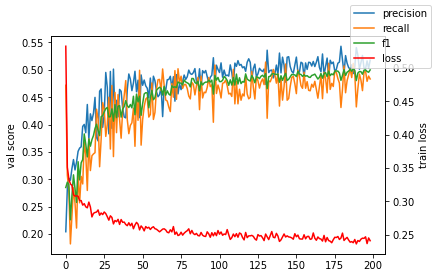

epoch 00/200 --- loss:0.532116  precision:0.2041  recall:0.4717   f:0.2849
epoch 01/200 --- loss:0.351088  precision:0.2828  recall:0.3074   f:0.2946
epoch 02/200 --- loss:0.333319  precision:0.3019  recall:0.2794   f:0.2902
epoch 03/200 --- loss:0.326094  precision:0.2982  recall:0.1818   f:0.2259
epoch 04/200 --- loss:0.323800  precision:0.3196  recall:0.2345   f:0.2705
epoch 05/200 --- loss:0.309750  precision:0.3360  recall:0.2844   f:0.3081
epoch 06/200 --- loss:0.307855  precision:0.3170  recall:0.2562   f:0.2833
epoch 07/200 --- loss:0.308231  precision:0.3313  recall:0.2108   f:0.2577
epoch 08/200 --- loss:0.307684  precision:0.3510  recall:0.3150   f:0.3320
epoch 09/200 --- loss:0.301019  precision:0.3570  recall:0.2570   f:0.2988
epoch 10/200 --- loss:0.301122  precision:0.3593  recall:0.3053   f:0.3301
epoch 11/200 --- loss:0.294314  precision:0.3966  recall:0.2914   f:0.3359
epoch 12/200 --- loss:0.296522  precision:0.4002  recall:0.3669   f:0.3828
epoch 13/200 --- loss:0.2

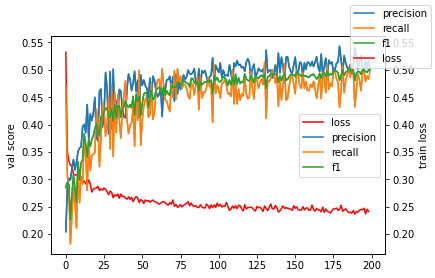

In [82]:
(lprecision,lrecall,lf)=train(train_loader, validate_loader,model, criterion, optimizer,scheduler,200,device,progress=2)
plt.plot(lprecision,label='precision')
plt.plot(lrecall,label='recall')
plt.plot(lf,label='f1')
plt.legend()

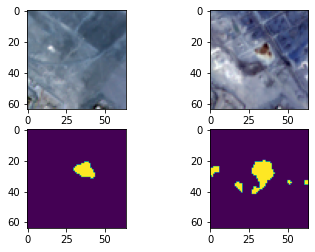

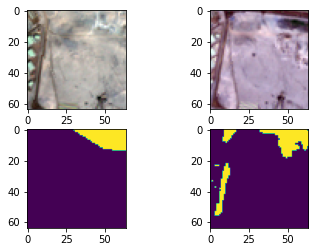

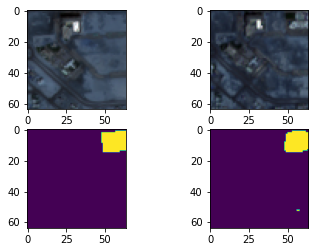

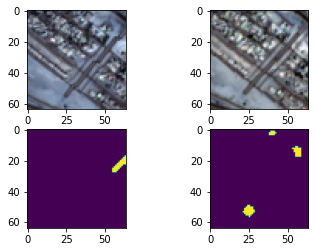

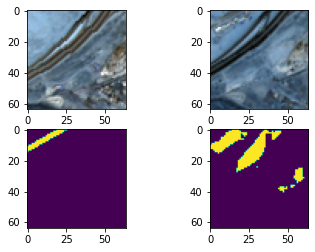

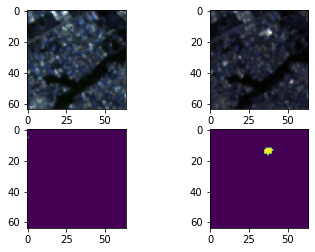

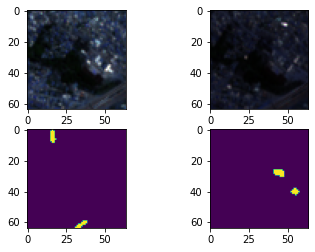

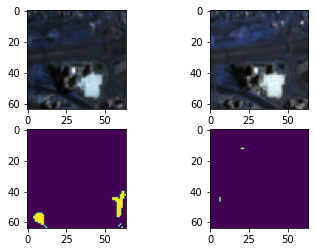

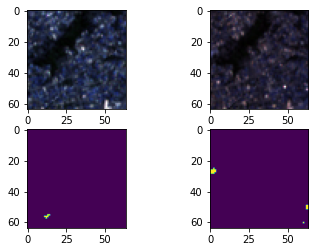

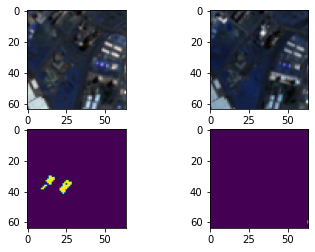

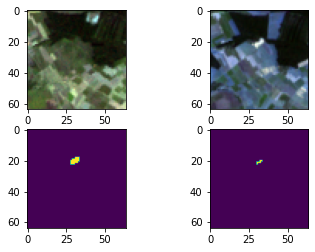

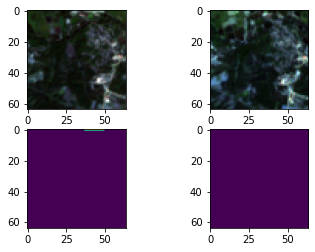

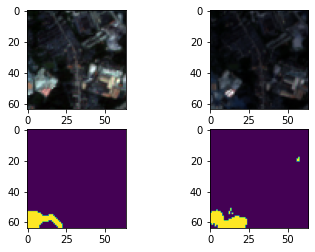

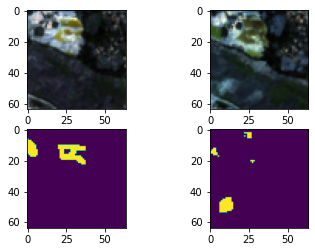

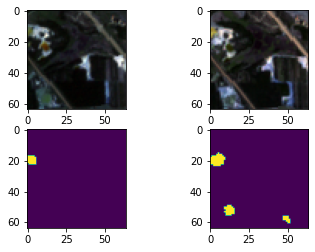

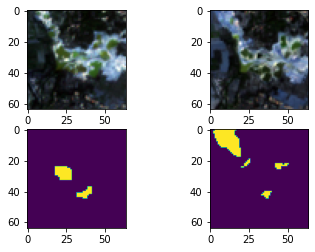

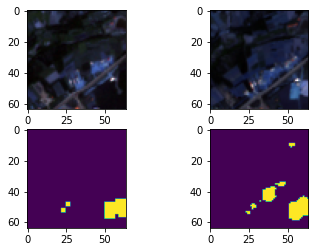

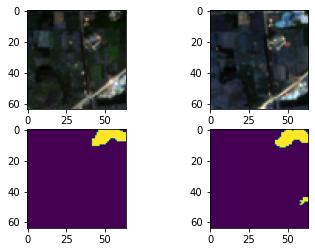

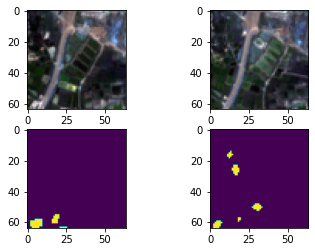

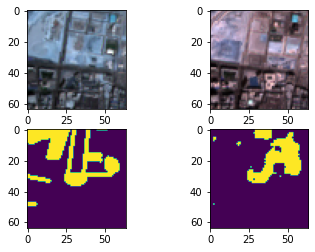

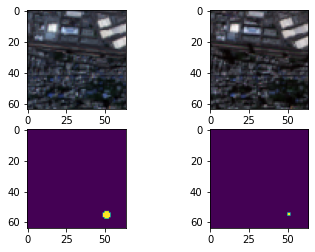

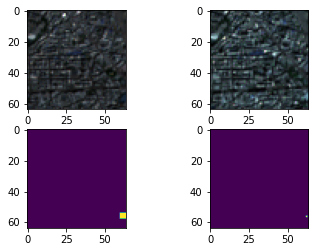

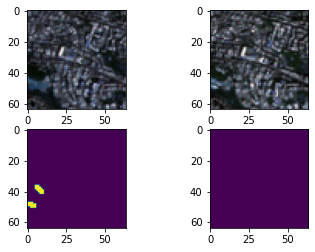

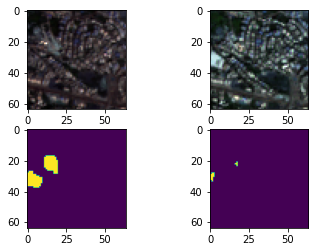

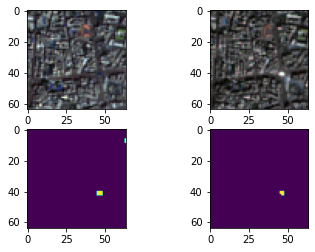

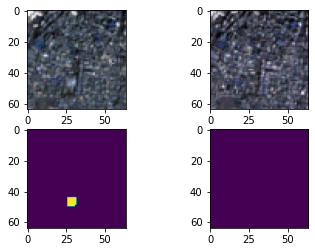

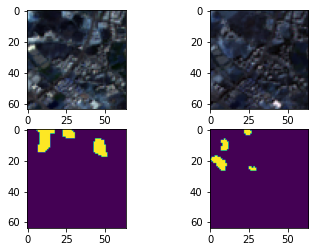

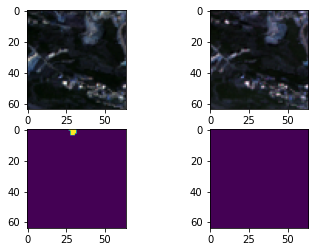

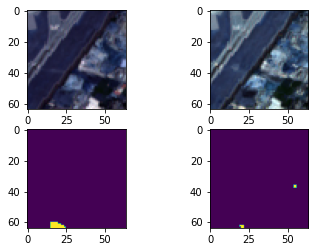

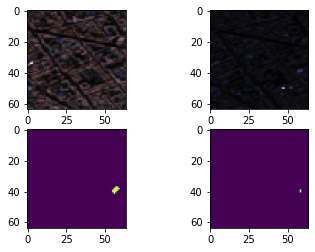

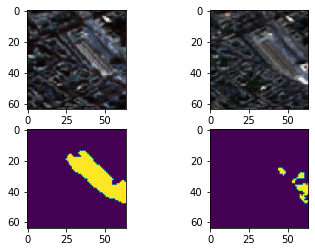

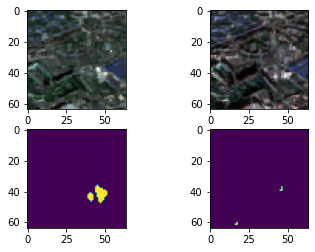

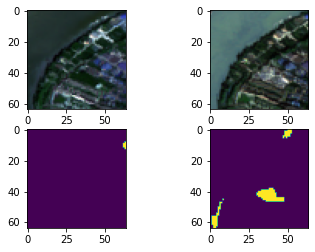

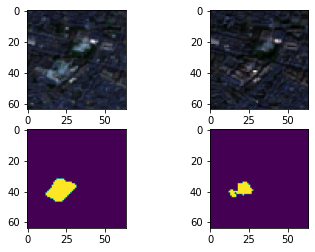

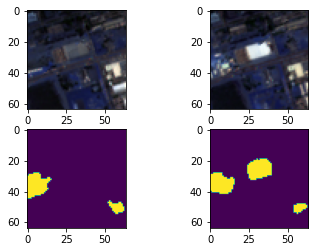

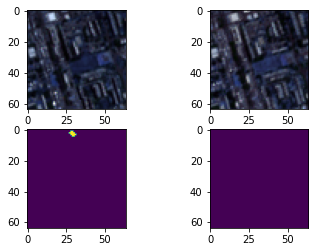

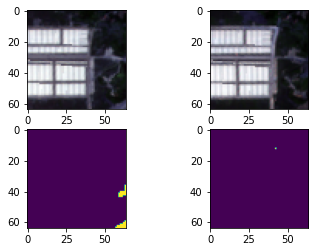

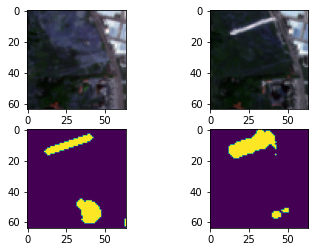

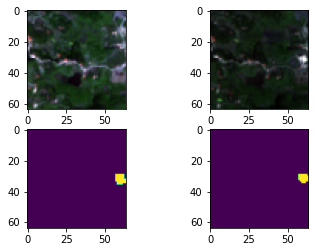

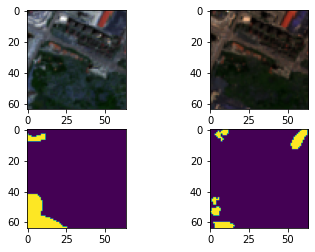

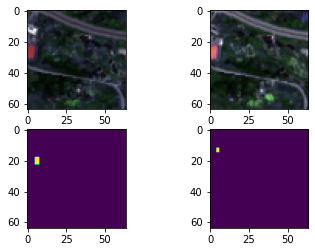

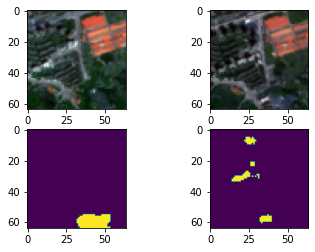

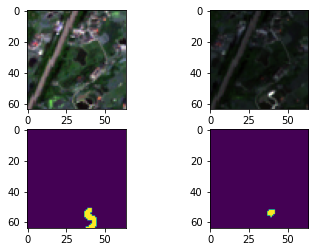

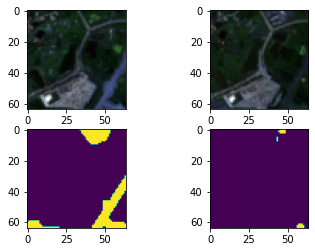

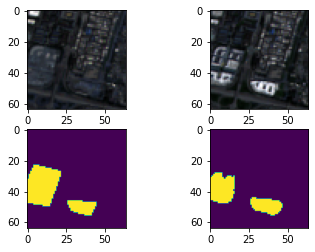

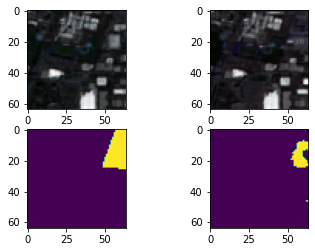

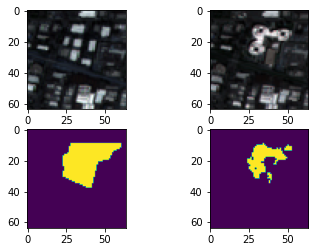

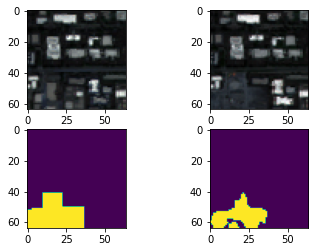

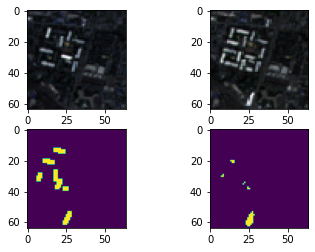

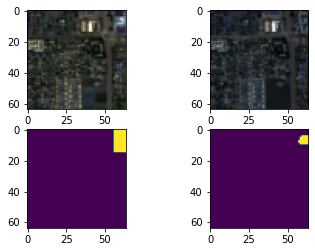

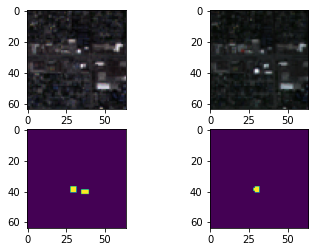

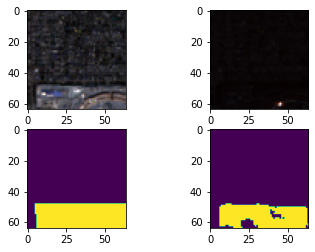

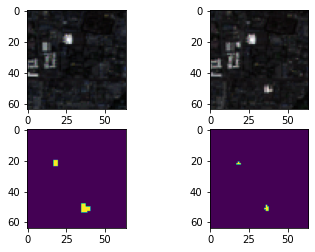

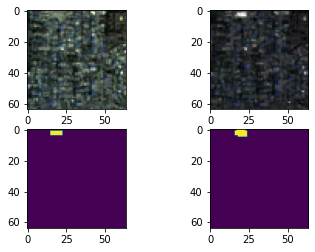

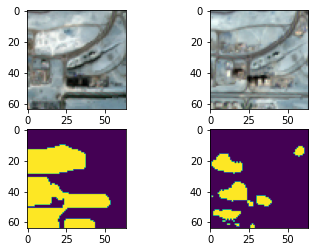

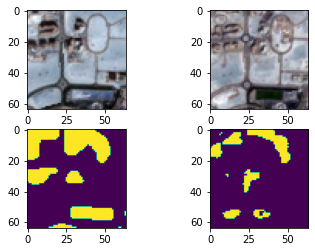

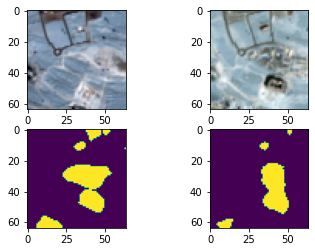

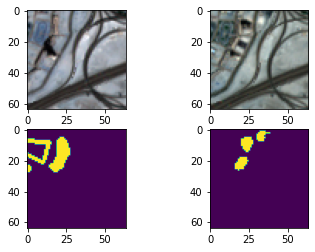

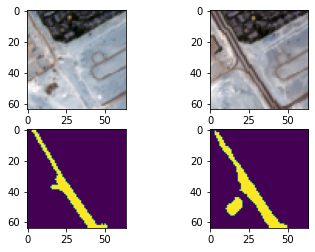

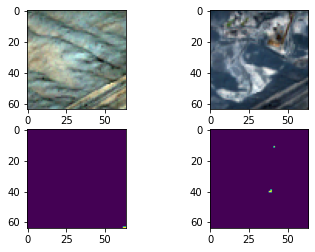

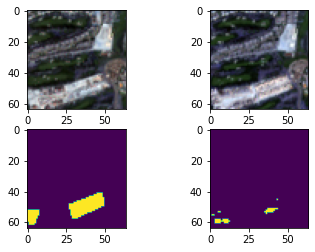

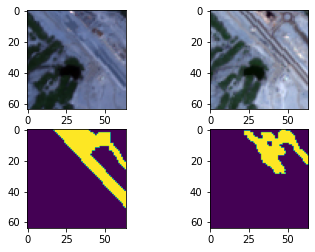

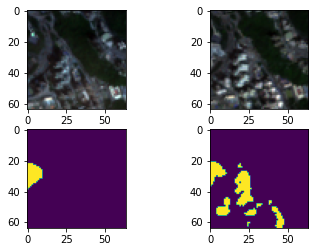

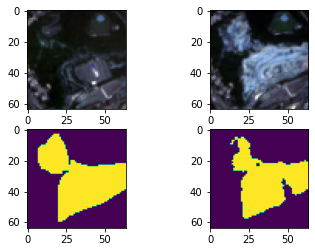

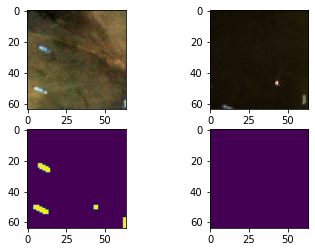

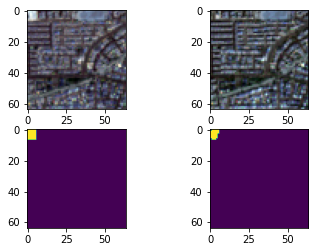

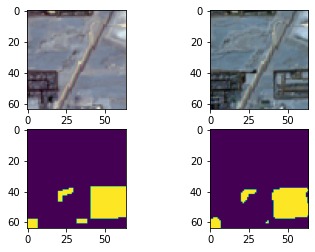

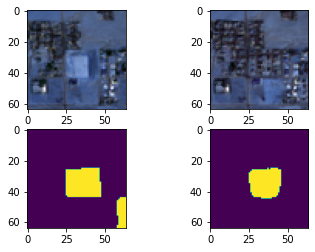

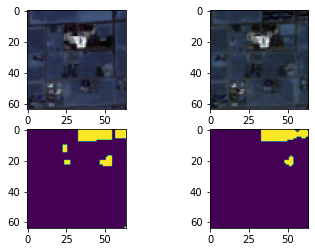

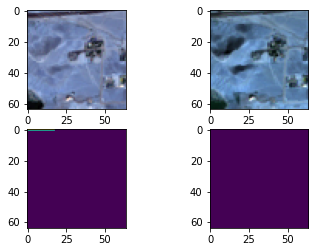

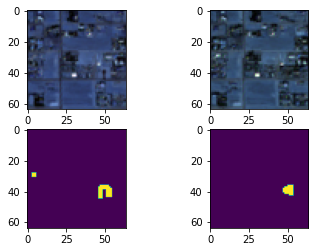

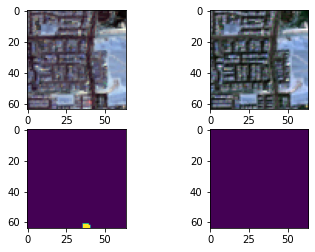

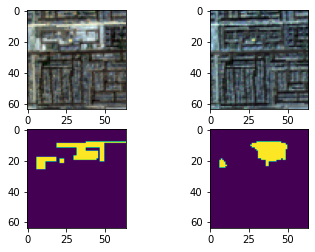

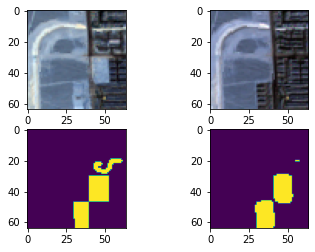

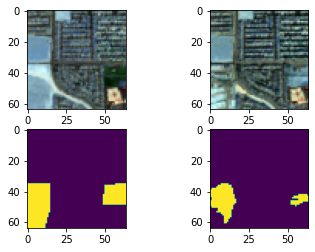

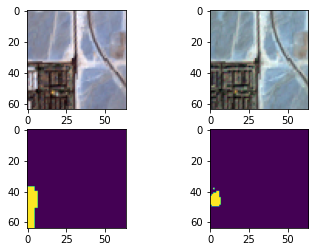

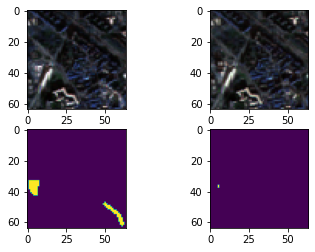

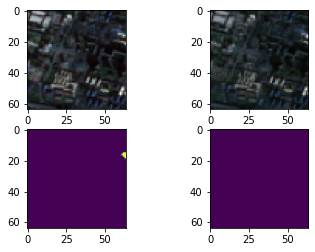

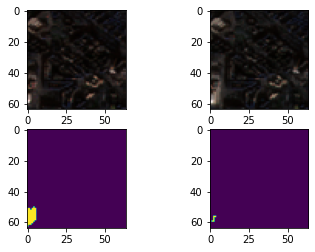

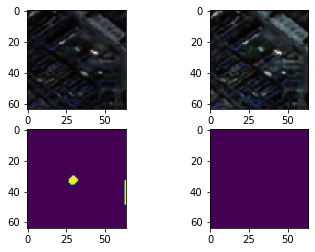

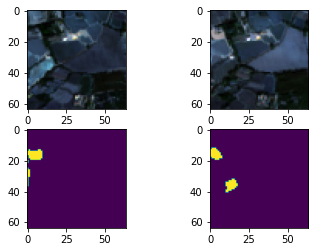

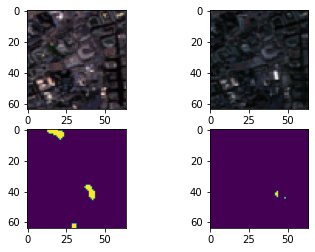

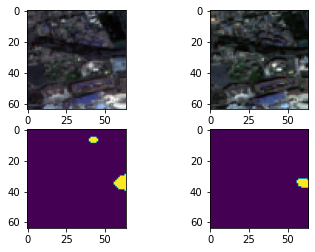

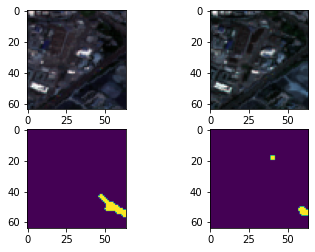

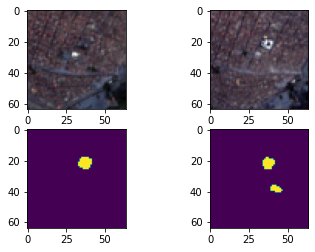

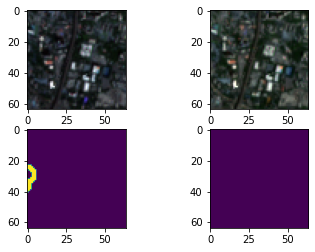

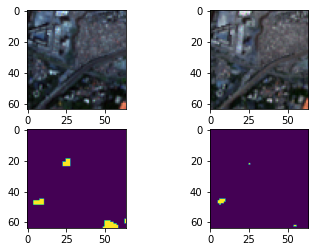

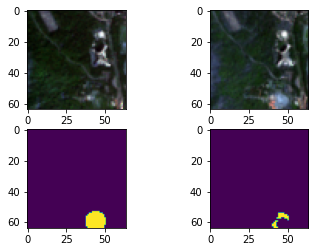

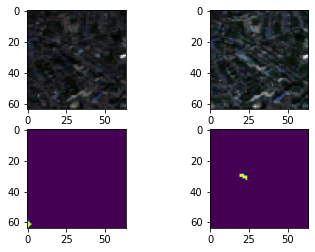

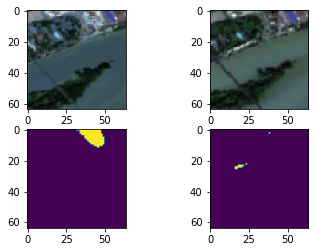

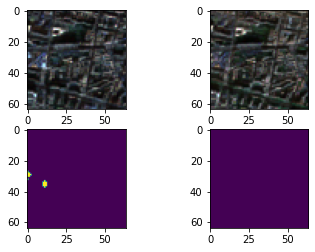

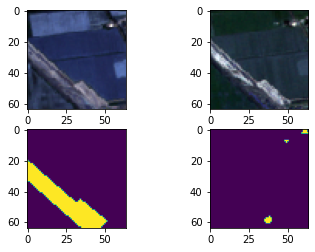

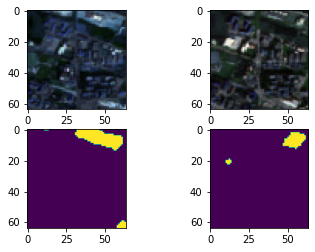

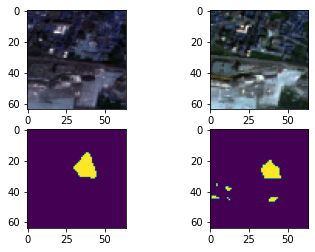

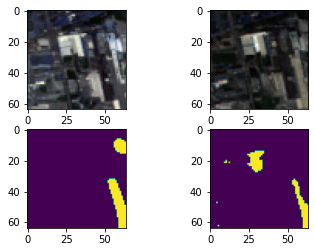

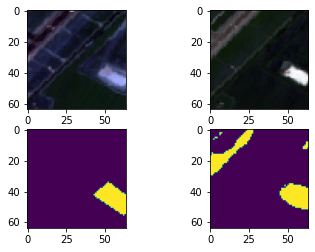

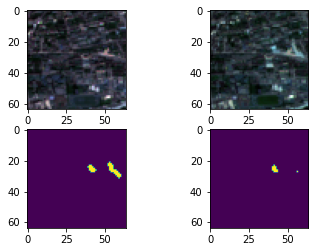

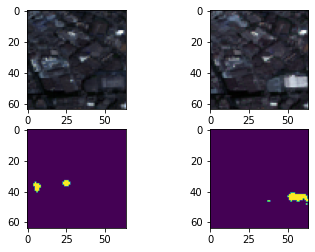

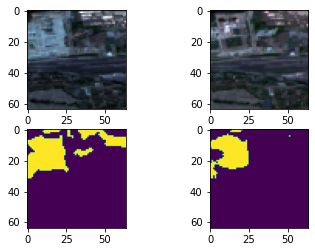

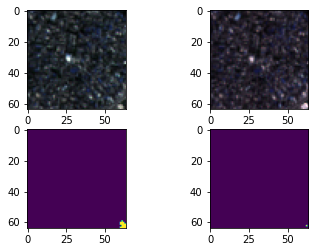

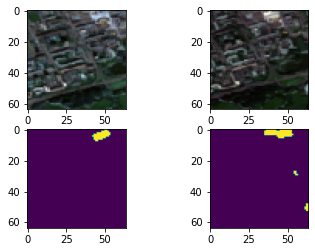

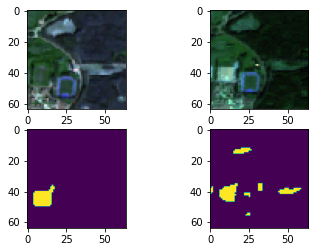

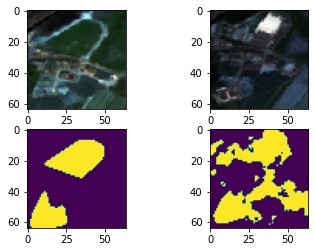

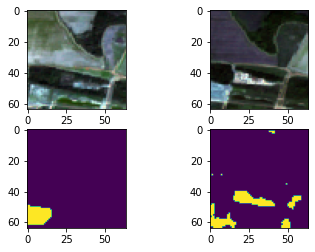

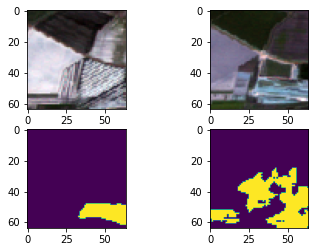

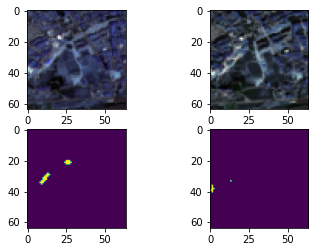

In [101]:
model.eval()
def dn(img):
    img=img-np.min(img,axis=(-1,-2))[:,None,None]
    img=img/np.max(img,axis=(-1,-2))[:,None,None]
    return img
for imgs in valds:
    if np.sum(imgs[2])==0: continue
    im1=torch.Tensor(imgs[0]).unsqueeze(0).to(device)
    im2=torch.Tensor(imgs[1]).unsqueeze(0).to(device)
    p=predict(im1,im2,model,device).cpu().numpy().astype(bool)
    f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2)
    ax1.imshow(dn(imgs[0]).transpose(1,2,0))
    ax2.imshow(dn(imgs[1]).transpose(1,2,0))
    ax3.imshow(imgs[2])
    ax4.imshow(p.squeeze())
    plt.show()
    
    